In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import json

from pyTrajectory.config import cfg
from pyTrajectory.data_structures import Trajectory
from pyTrajectory.dataset import Dataset, AnnotatedGroup
from pyTrajectory.features import DataFrameFeatureExtractor

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler

from xgboost import XGBClassifier

import pandas as pd
import numpy as np

from pyTrajectory.dataset import to_annotations

cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

ModuleNotFoundError: No module named 'pyTrajectory'

In [3]:
def load_calms21_dataset(calms21_json_file):
    dataset = []
    with open(calms21_json_file) as json_file:
        json_data = json.load(json_file)
        for data in json_data.values():
            for pair in [key for key in data.keys()]:
                pair_data = data.pop(pair)
                annotations = to_annotations(
                    np.asarray(pair_data["annotations"]),
                    category_names = ["attack", "investigation", "mount", "other"],
                    drop=["other"]
                )
                annotations["actor"] = "resident"
                annotations["recipient"] = "intruder"
                dataset.append(
                    (
                        {
                            "resident": Trajectory(
                                data={
                                    "keypoints": np.asarray(pair_data["keypoints"])[:, 0].transpose(0, 2, 1),
                                    "timestamps": np.arange(len(pair_data["keypoints"])),
                                }
                            ),
                            "intruder": Trajectory(
                                data={
                                    "keypoints": np.asarray(pair_data["keypoints"])[:, 1].transpose(0, 2, 1),
                                    "timestamps": np.arange(len(pair_data["keypoints"])),
                                }
                            ),
                        },
                        annotations,
                    )
                )
    del data
    return dataset

In [4]:
dataset_train = Dataset(
    [
        AnnotatedGroup(
            trajectories,
            target="dyads",
            annotations=annotations,
            categories=("attack", "investigation", "mount"),
        )
        for trajectories, annotations
        in load_calms21_dataset("/home/paul/A-SOID/task1_classic_classification/calms21_task1_train.json")
    ]
)

In [5]:
dataset_test = Dataset(
    [
        AnnotatedGroup(
            trajectories,
            target="dyads",
            annotations=annotations,
            categories=("attack", "investigation", "mount"),
        )
        for trajectories, annotations
        in load_calms21_dataset("/home/paul/A-SOID/task1_classic_classification/calms21_task1_test.json")
    ]
)

In [6]:
# {
#     0: "nose",
#     1: "left ear",
#     2: "right ear",
#     3: "neck",
#     4: "left hip",
#     5: "right hip",
#     6: "tail base",
# }

feature_config = {
    "individual": [
        # step 5
        ("speed", {"step": 5, "keypoints": (0, 3, 6)}),
        ("projected_velocity", {"step": 5, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "discard": "-rej"}),
        ("projected_velocity", {"step": 5, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "as_absolute": True, "discard": "-proj"}),
        ("orientation_change", {"step": 5, "keypoint_pairs": ((3, 0), (6, 3)), "as_absolute": True}),
        # step 30
        ("speed", {"step": 30, "keypoints": (0, 3, 6)}),
        ("projected_velocity", {"step": 30, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "discard": "-rej"}),
        ("projected_velocity", {"step": 30, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "as_absolute": True, "discard": "-proj"}),
        ("orientation_change", {"step": 30, "keypoint_pairs": ((3, 0), (6, 3)), "as_absolute": True}),
        # step 15
        ("speed", {"step": 15, "keypoints": (0, 3, 6)}),
        ("projected_velocity", {"step": 15, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "discard": "-rej"}),
        ("projected_velocity", {"step": 15, "keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoint_pairs_2": ((6, 3), ), "as_absolute": True, "discard": "-proj"}),
        ("orientation_change", {"step": 15, "keypoint_pairs": ((3, 0), (3, 1), (3, 2), (6, 3), (6, 4), (6, 5)), "as_absolute": True}),
        (
            "posture_angles",
            {
                "keypoint_pairs_1": ((6, 3), (3, 0), (3, 0), (6, 3), (6, 3)),
                "keypoint_pairs_2": ((3, 0), (3, 1), (3, 2), (6, 4), (6, 5)),
                "element_wise": True
            }
        ),
    ],
    "dyadic": [
        ("target_velocity", {"step": 5, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "discard": "-rej"}),
        ("target_velocity", {"step": 30, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "discard": "-rej"}),
        ("target_velocity", {"step": 15, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "discard": "-rej"}),
        ("target_velocity", {"step": 5, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "as_absolute": True, "discard": "-proj"}),
        ("target_velocity", {"step": 30, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "as_absolute": True, "discard": "-proj"}),
        ("target_velocity", {"step": 15, "keypoints_1": (0, 3), "keypoint_pairs_2": ((0, 0), (0, 3), (0, 6), (3, 0), (3, 3), (3, 6)), "as_absolute": True, "discard": "-proj"}),
        ("keypoint_distances", {"keypoints_1": (0, 1, 2, 3, 4, 5, 6), "keypoints_2": (0, 1, 2, 3, 4, 5, 6)}),
        ("target_angles", {"keypoint_pairs_1": ((3, 0), (6, 3)), "keypoints_2": (0, 1, 2, 3, 4, 5, 6), "as_absolute": True}),
        ("posture_alignment", {"keypoint_pairs_1": ((3, 0), (6, 3)), "keypoint_pairs_2": ((3, 0), (6, 3))}),
    ]
    
}

extractor = DataFrameFeatureExtractor().load(feature_config)

In [7]:
X_train, y_train = dataset_train.subsample(
    extractor,
    0.1,
    pipeline=KNNImputer(),
    exclude=[("intruder", "resident")],
)

X_test, y_test = dataset_test.sample(
    extractor,
    pipeline=KNNImputer(),
    exclude=[("intruder", "resident")],
)

In [8]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, category_labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_prob = (cm.T / cm.sum(axis=1)).T
    
    fig = plt.figure(figsize=(3, 3), dpi=100)
    axes = fig.subplots(1, 2, width_ratios=[20, 1])
    mappable = axes[0].matshow(cm_prob, vmin=0, vmax=1)
    grid = np.indices(cm_prob.shape)
    for row_idx, col_idx in zip(grid[0].ravel(), grid[1].ravel()):
        axes[0].text(
            col_idx,
            row_idx,
            f"{cm_prob[row_idx, col_idx]:.2f}\n({cm[row_idx, col_idx]})",
            ha="center",
            va="center",
            c="k" if cm_prob[row_idx, col_idx] > 0.5 else "w",
            fontsize=8,
        )
    
    plt.colorbar(mappable, cax=axes[1])
    
    axes[0].set_yticks(range(len(category_labels)))
    axes[0].set_yticklabels(category_labels, rotation=90, va="center")
    axes[0].set_ylabel("Annotated")
    
    axes[0].set_xticks(range(len(category_labels)))
    axes[0].set_xticklabels(category_labels)
    axes[0].set_xlabel("Predicted")
    
    axes[0].xaxis.set_ticks_position("bottom")
    axes[1].yaxis.set_ticks_position("right")
    
    bbox = axes[0].get_position()
    bbox_cbar = axes[1].get_position()
    bbox_cbar.intervaly = bbox.intervaly
    axes[1].set_position(bbox_cbar)
    plt.show()

In [9]:
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

In [10]:
xgbc = XGBClassifier().fit(
    X_train.to_numpy(),
    dataset_train.encode(y_train),
    sample_weight=compute_sample_weight("balanced", dataset_train.encode(y_train)),
)

In [11]:
xgbc_smote = XGBClassifier().fit(
    X_smote.to_numpy(),
    dataset_train.encode(y_smote),
    sample_weight=compute_sample_weight("balanced", dataset_train.encode(y_smote)),
)

In [12]:
rfc = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced_subsample",
    n_jobs=-1,
).fit(
    X_train,
    dataset_train.encode(y_train),
)

In [18]:
rfc_smote = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced_subsample",
    n_jobs=-1,
).fit(
    X_smote,
    dataset_train.encode(y_smote),
)


KeyboardInterrupt



In [13]:
y_test_categorical = np.argmax(dataset_test.encode(y_test), axis=1)

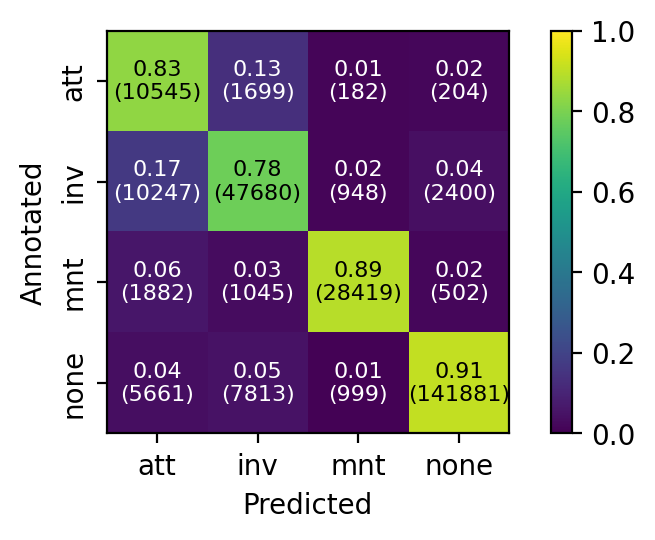

[0.51482973 0.79791151 0.91092378 0.94166409]


In [14]:
y_pred = xgbc_smote.predict(X_test)
y_pred_categorical = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test_categorical, y_pred_categorical, ["att", "inv", "mnt", "none"])
print(f1_score(y_test_categorical, y_pred_categorical, average=None))

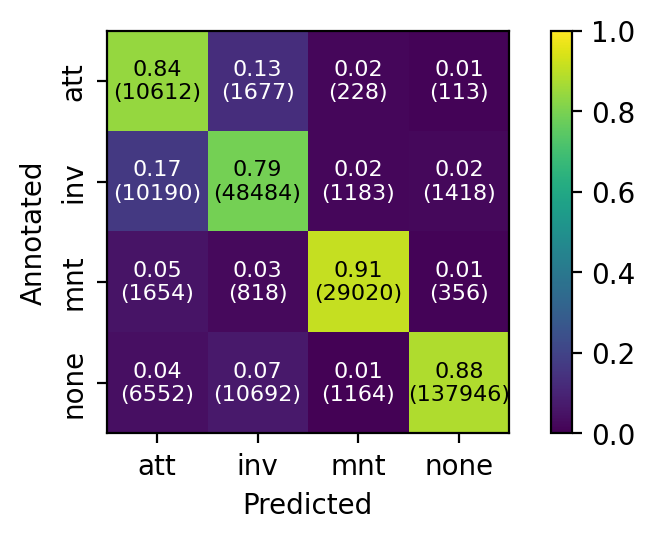

[0.50972669 0.78870398 0.91483694 0.9314791 ]


In [15]:
y_pred = xgbc.predict(X_test)
y_pred_categorical = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test_categorical, y_pred_categorical, ["att", "inv", "mnt", "none"])
print(f1_score(y_test_categorical, y_pred_categorical, average=None))

In [ ]:
y_pred = rfc_smote.predict(X_test)
y_pred_categorical = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test_categorical, y_pred_categorical, ["att", "inv", "mnt", "none"])
print(f1_score(y_test_categorical, y_pred_categorical, average=None))

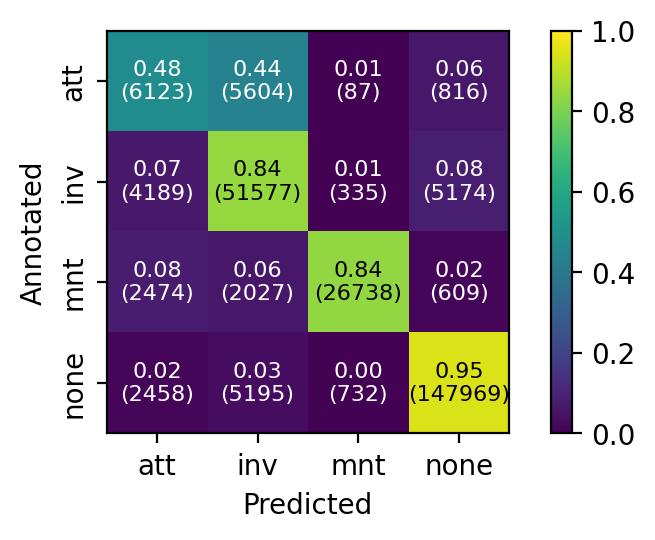

[0.43933415 0.82078009 0.89514563 0.95180785]


In [17]:
y_pred = rfc.predict(X_test)
y_pred_categorical = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test_categorical, y_pred_categorical, ["att", "inv", "mnt", "none"])
print(f1_score(y_test_categorical, y_pred_categorical, average=None))

In [ ]:
from pyTrajectory.series_operations import smooth
from scipy.signal import medfilt, savgol_filter
from pyTrajectory.math import unit_vector

for idx in range(len(dataset_test._groups)):
    dyad = dataset_test.select(idx).select(("resident", "intruder"))
    X_dyad, y_dyad = dyad.sample(extractor)
    
    y_dyad_pred = xgbc.predict(X_dyad)
    y_dyad_pred_categorical = np.argmax(y_dyad_pred, axis=1)
    
    y_dyad_categorical = np.argmax(dataset_test.encode(y_dyad), axis=1)
    
    plot_confusion_matrix(y_dyad_categorical, y_dyad_pred_categorical, ["att", "inv", "mnt", "none"])
    print(f1_score(y_dyad_categorical, y_dyad_pred_categorical, average=None))
    
    y_dyad_proba = xgbc.predict_proba(X_dyad)
    
    y_dyad_proba_smoothed = smooth(y_dyad_proba, filter_funcs=[lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, 5, 1)])
    y_dyad_categorical_smoothed = np.argmax(y_dyad_proba_smoothed, axis=1)
    
    categories = dyad.categories
    
    predictions = to_annotations(y_dyad_categorical_smoothed, categories)
    annotations = dyad.annotations
    
    fig, axes = plt.subplots(y_dyad_proba.shape[1], 1, sharey=True, figsize=(10, 3), dpi=100)
    for idx in range(y_dyad_proba.shape[1]):
        try:
            axes[idx].broken_barh(predictions.set_index("category").loc[[categories[idx]], ["start", "duration"]].to_numpy(), yrange=(0, 0.5), lw=0, color="red", alpha=0.5)
            axes[idx].broken_barh(annotations.set_index("category").loc[[categories[idx]], ["start", "duration"]].to_numpy(), yrange=(0.5, 0.5), lw=0, color="gray", alpha=0.5)
        except KeyError as e:
            pass
        axes[idx].plot(y_dyad_proba[:500, idx], lw=1, c="k", alpha=0.5)
        axes[idx].plot(y_dyad_proba_smoothed[:1000, idx], lw=1, c="k")
        axes[idx].spines[["right", "top", "bottom"]].set_visible(False)
        axes[idx].set_xticks([])
        axes[idx].set_xlim(0, 499)
        axes[idx].set_ylabel(["att", "inv", "mnt", "none"][idx])
    plt.show()